created by Ignacio Oguiza - email: oguiza@gmail.com

## How to work with numpy arrays in fastai2: a time series classification example ⏳ 

I'd like to share with you how you can work with numpy arrays in **fastai2** through a time series classification example. To be able to use fastai v2 I have a few requirements: 


* Use univariate and multivariate time series
* Use labeled (X,y) and unlabeled (X,) datasets
* Data may be already split in train/ valid
* In-memory and on-disk np.arrays (np.memmap in case of larger than RAM data)
* Slice the dataset (based on selected variables and/ or sequence steps)
* Use item and batch tfms
* Create batch with specified output types (TSTensor, TensorCategory, etc)
* Show batch (with tfms)
* Show results
* Add test data and unlabeled datasets
* Export and predict on new data
* Equal or better performance than native Pytorch, fastai v1 & vanilla fastai v2

These are pretty challanging. Let's see if fastai2 can meet them (with limited customization).

## Import libraries 📚

In [3]:
import sys
import os
ISCOLAB = 'google.colab' in sys.modules
if ISCOLAB:
    if not os.path.isdir('/content/timeseriesAI2'):
        !pip install git+https://github.com/fastai/fastai2 
        !pip install git+https://github.com/fastai/fastcore 
        !pip install pyunpack
        !pip install sktime
        !git clone https://github.com/timeseriesAI/timeseriesAI2.git
        %cd timeseriesAI2
    else: 
        path = !pwd
        if path != ['/content/timeseriesAI2']: 
            %cd timeseriesAI2
        !pwd

In [4]:
# # Uncomment if need to reload repo
# %cd ..
# !rm -rf timeseriesAI2

# !git clone https://github.com/timeseriesAI/timeseriesAI2.git
# %cd timeseriesAI2

In [5]:
from timeseries import *
display(HTML("<style>.container {width:95% !important; }</style>"))

In [4]:
print('fastai2    :', fastai2.__version__)
print('fastcore   :', fastcore.__version__)
print('torch      :', torch.__version__)
print('scipy      :', sp.__version__)
print('numpy      :', np.__version__)
print('pandas     :', pd.__version__)
print(f'Total RAM  : {bytes2GB(psutil.virtual_memory().total):5.2f} GB')
print(f'Used RAM   : {bytes2GB(psutil.virtual_memory().used):5.2f} GB')
print('n_cpus     :', cpus)
iscuda = torch.cuda.is_available()
if iscuda: print('device     : {} ({})'.format(device, torch.cuda.get_device_name(0)))
else: print('device     :', device)

fastai2    : 0.0.17
fastcore   : 0.1.17
torch      : 1.4.0
scipy      : 1.4.1
numpy      : 1.18.2
pandas     : 1.0.3
Total RAM  : 12.72 GB
Used RAM   :  0.66 GB
n_cpus     : 2
device     : cuda (Tesla P100-PCIE-16GB)


## Load data 🔢

In [6]:
# dataset id
dsid = 'StarLightCurves'
X_train, y_train, X_valid, y_valid = get_UCR_data(dsid, parent_dir='./data/UCR/', verbose=True, on_disk=True)
X_in_memory = np.concatenate((X_train, X_valid))
y_in_memory = np.concatenate((y_train, y_valid))
folder = './data/UCR'
np.save(f'{folder}/{dsid}/X.npy', X_in_memory)
np.save(f'{folder}/{dsid}/y.npy', y_in_memory)
X_on_disk = np.load(f'{folder}/{dsid}/X.npy', mmap_mode='r')
y_on_disk = np.load(f'{folder}/{dsid}/y.npy', mmap_mode='r')
splits = (L(list(np.arange(len(X_train)))), L(list(np.arange(len(X_train), len(X_on_disk)))))

Dataset: StarLightCurves
...data downloaded and decompressed
X_train: (1000, 1, 1024)
y_train: (1000,)
X_valid: (8236, 1, 1024)
y_valid: (8236,) 



## Building block: NumpyTensor/ TSTensor 🧱

Since fastai is based on Pytorch, you'll need to somehow transform the numpy arrays to tensors at some point (NumpyTensor or TSTensor in our case). There's a transform function called ToNumpyTensor/ ToTSTensor that transforms an array into a tensor of type NumpyTensor/ TSTensor (which have a show method).

In [6]:
class NumpyTensor(TensorBase):
    def __new__(cls, o, **kwargs): 
        res = tensor(o)
        res.__class__ = cls
        res._meta = kwargs
        return res
    
    def __getitem__(self, idx):
        res = super().__getitem__(idx)
        return self.__class__(res)

    def __repr__(self):
        return f'NumpyTensor(shape:{list(self.shape)})'

    def show(self, ax=None, ctx=None, title=None, title_color='black', **kwargs):
        if self.ndim != 2: self = self.__class__(To2DTensor(self))
        ax = ifnone(ax,ctx)
        if ax is None: fig, ax = plt.subplots(**kwargs)
        ax.plot(self.T)
        ax.axis(xmin=0, xmax=self.shape[-1] - 1)
        ax.set_title(title, weight='bold', color=title_color)
        plt.tight_layout()
        return ax

@Transform
def ToNumpyTensor(o:(np.ndarray, torch.Tensor)): 
    return NumpyTensor(o)

In [7]:
class TSTensor(TensorBase):
    '''Returns a tensor oftype torch.float32 and class TSTensor'''
    def __new__(cls, o, **kwargs): 
        res = tensor(o)
        res.__class__ = cls
        res._meta = kwargs
        return res

    @property
    def vars(self): return self.shape[-2]

    @property
    def length(self): return self.shape[-1]
    
    def __getitem__(self, idx):
        res = super().__getitem__(idx)
        return self.__class__(res)

    def __repr__(self):
        if self.ndim >= 3:   return f'TSTensor(samples:{self.shape[-3]}, vars:{self.shape[-2]}, len:{self.shape[-1]})'
        elif self.ndim == 2: return f'TSTensor(vars:{self.shape[-2]}, len:{self.shape[-1]})'
        elif self.ndim == 1: return f'TSTensor(len:{self.shape[-1]})'
        else: return f'TSTensor(float)'

    def show(self, ax=None, ctx=None, title=None, title_color='black', **kwargs):
        if self.ndim != 2: self = self.__class__(To2DTensor(self))
        ax = ifnone(ax,ctx)
        if ax is None: fig, ax = plt.subplots(**kwargs)
        ax.plot(self.T)
        ax.axis(xmin=0, xmax=self.shape[-1] - 1)
        ax.set_title(title, weight='bold', color=title_color)
        plt.tight_layout()
        return ax

@Transform
def ToTSTensor(o:(np.ndarray, torch.Tensor), dtype=torch.float32, **kwargs): 
    """ Transforms input to tensor of dtype torch.float32"""
    return TSTensor(o, dtype=dtype, **kwargs)

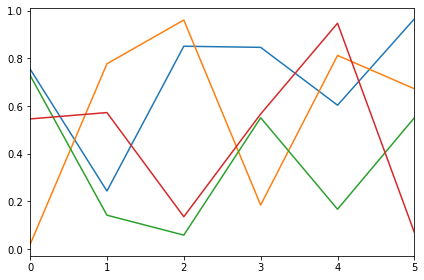

In [8]:
nt = NumpyTensor(np.random.rand(4, 6))
nt.show();

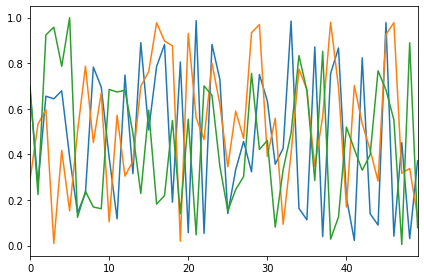

In [9]:
tstensor = TSTensor(np.random.rand(10, 3, 50))
tstensor[0].show();

## Performance benchmarks ⏱

In fastai v2 there are multiple options to creaet a dataloaders. Let's see some of them and most importantly wheteher they meet our requirements.

I will compare 2 processes: 

- cycle_dl: process to load the entire valid dataset (adapted from a function developed by Thomas Capelle (fastai's @tcapelle))
- train model for 25 epochs

### Generic Pytorch dataloader

In [0]:
# # Native Pytorch
# class PytorchDataset():
#     def __init__(self, X, y=None): self.X, self.y = torch.as_tensor(X), torch.as_tensor(y)
#     def __getitem__(self, idx): return (self.X[idx], self.y[idx])
#     def __len__(self): return len(self.X)

In [11]:
ds    = PytorchDataset(np.array(X_valid), np.array(y_valid).astype(int))
dl    = torch.utils.data.DataLoader(ds, batch_size=128)
xb,yb = next(iter(dl))
print(f'shape: {str(len(ds)):10}   bs: {xb.shape}')
%timeit cycle_dl(dl)

shape: 8236         bs: torch.Size([128, 1, 1024])
10 loops, best of 3: 47.2 ms per loop


This is the most simple dataset we can have. This doesn't allow us to perform any transforms, show_batch, etc. It cannot be used inside fastai.

I've included it for reference, as this dataloader is pretty fast (around 50 ms to cycle the entire dataset). This will be difficult to beat 😅!

### Fastai v1

For comparison, I've run the same exact test in the same machine with fastai v1 timeseries code and these are the timings: : 

- cycle_dl:  1.01s
- training time: 102 s

This 102 seconds is what we'll try to beat.

### Fastai v2:  Factory method

In [0]:
class TSDataLoaders(DataLoaders):
    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_numpy(cls, X, y=None, splitter=None, valid_pct=0.2, seed=0, item_tfms=None, batch_tfms=None, **kwargs):
        "Create timeseries dataloaders from arrays (X and y, unless unlabeled)"
        if splitter is None: splitter = RandomSplitter(valid_pct=valid_pct, seed=seed)
        getters = [ItemGetter(0), ItemGetter(1)] if y is not None else [ItemGetter(0)]
        dblock = DataBlock(blocks=(TSTensorBlock, CategoryBlock),
                           getters=getters,
                           splitter=splitter,
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms)

        source = itemify(X) if y is None else itemify(X,y)
        return cls.from_dblock(dblock, source, **kwargs)

In [13]:
dls = TSDataLoaders.from_numpy(X_in_memory, y_in_memory, splitter=IndexSplitter(splits[1]), bs=64, val_bs=128)
t = next(iter(dls.valid))
t

(TSTensor(samples:128, vars:1, len:1024),
 TensorCategory([1, 2, 2, 0, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 0, 2, 2, 2,
         1, 0, 2, 0, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 0, 2, 2, 1, 0, 0, 2,
         2, 2, 2, 1, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 1, 2, 2, 1, 2, 2, 2, 0, 0, 2,
         1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 0, 2, 0, 2,
         2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 0, 2, 2, 0, 2, 2, 1, 2, 1, 2, 2,
         2, 2, 2, 2, 1, 2, 2, 0], device='cuda:0'))

In [14]:
%time cycle_dl(dls.valid)

CPU times: user 94.1 ms, sys: 60.9 ms, total: 155 ms
Wall time: 3.02 s


In [15]:
model = InceptionTime(X_in_memory.shape[-2], dls.c)
learn = Learner(dls, model, metrics=accuracy)
start = time.time()
learn.fit_one_cycle(25, lr_max=1e-3)
print(time.time() - start)

epoch,train_loss,valid_loss,accuracy,time
0,0.773913,1.076612,0.143273,00:05
1,0.620511,0.692732,0.837057,00:05
2,0.514848,0.467747,0.847013,00:05
3,0.434807,2.182418,0.419500,00:05
4,0.368843,2.002529,0.431277,00:05
5,0.307304,0.394070,0.855634,00:05
6,0.260759,0.160155,0.945119,00:05
7,0.226270,0.158245,0.952040,00:05
8,0.198179,0.121649,0.968674,00:05
9,0.172922,0.105524,0.976202,00:05


129.90362572669983


This method is very easy to use, but it's pretty slow.

### Fastai v2:  Datablock API

In [0]:
class TSTensorBlock():
    "A basic wrapper that links defaults transforms for the data block API"
    def __init__(self, type_tfms=None, item_tfms=None, batch_tfms=None, dl_type=None, dls_kwargs=None):
        self.type_tfms  =              L(type_tfms)
        self.item_tfms  = ToTSTensor + L(item_tfms)
        self.batch_tfms =              L(batch_tfms)
        self.dl_type,self.dls_kwargs = dl_type,({} if dls_kwargs is None else dls_kwargs)

In [17]:
getters = [ItemGetter(0), ItemGetter(1)]
dblock = DataBlock(blocks=(TSTensorBlock, CategoryBlock()),
                   getters=getters,
                   splitter=IndexSplitter(splits[1]),
                   item_tfms=None,
                   batch_tfms=None)
source = itemify(X_in_memory, y_in_memory)
dls = dblock.dataloaders(source, bs=64, val_bs=128, num_workers=0)
xb,yb = next(iter(dls.valid))
print(f'shape: {str(len(dls.valid.dataset)):10}   bs: {xb.shape}')
%timeit cycle_dl(dls.valid)

shape: 8236         bs: torch.Size([128, 1, 1024])
1 loop, best of 3: 3.26 s per loop


So it takes > 3 s to cycle the entire dataloader. This is much slower than Pytorch simple model (although fastai v2 provides a lot more functionality!).

In [18]:
model = InceptionTime(X_in_memory.shape[-2], dls.c)
learn = Learner(dls, model, metrics=accuracy)
start = time.time()
learn.fit_one_cycle(25, lr_max=1e-3)
print(time.time() - start)

epoch,train_loss,valid_loss,accuracy,time
0,0.737062,1.041777,0.279869,00:07
1,0.594224,0.738383,0.850534,00:06
2,0.494184,0.548935,0.827465,00:06
3,0.415249,0.372656,0.855877,00:06
4,0.348832,0.458948,0.856605,00:06
5,0.302510,1.211509,0.682856,00:06
6,0.262590,0.199042,0.960539,00:06
7,0.222744,0.188022,0.968796,00:06
8,0.192664,0.101375,0.975474,00:06
9,0.167375,0.122871,0.967339,00:06


166.2942316532135


This is very slow compared to the native Pytorch, and even to fastai v1.

### Mixed Pytorch dataset + Fastai DataLoaders



Sylvain Gugger provided an alternative recommendation to use numpy arrays in this [post](https://forums.fast.ai/t/datablock-with-numpy-input/64848/2):

"You can create a DataLoaders object from regular PyTorch datasets (though all the visualization methods like show_batch and show_results will fail)."

In [19]:
train_ds = PytorchDataset(np.array(X_train), np.array(y_train).astype(int) - 1)
valid_ds = PytorchDataset(np.array(X_valid), np.array(y_valid).astype(int) - 1)
dls = DataLoaders.from_dsets(train_ds, valid_ds, batch_size=128, num_workers=0, device=default_device())
xb,yb = next(iter(dls.valid))
print(f'shape: {str(len(dls.valid.dataset)):10}   bs: {xb.shape}')
%timeit cycle_dl(dls.valid)

shape: 8236         bs: torch.Size([128, 1, 1024])
1 loop, best of 3: 772 ms per loop


In [20]:
model = InceptionTime(X_in_memory.shape[-2], len(np.unique(y_in_memory)))
learn = Learner(dls, model, loss_func=nn.CrossEntropyLoss(), metrics=accuracy)
start = time.time()
learn.fit_one_cycle(25, lr_max=1e-3)
print(time.time() - start)

epoch,train_loss,valid_loss,accuracy,time
0,0.907794,1.104778,0.279869,00:03
1,0.758172,1.036763,0.776712,00:03
2,0.656297,0.856869,0.835357,00:03
3,0.582669,0.654162,0.840457,00:03
4,0.524617,0.625574,0.854662,00:03
5,0.471048,0.542751,0.853448,00:03
6,0.428712,0.262246,0.923749,00:03
7,0.387910,0.352556,0.855634,00:03
8,0.349279,0.272079,0.963089,00:03
9,0.313974,0.204339,0.963939,00:03


92.88428354263306


This is definitely an improvement in terms of speed.

It is now better than fastai v1, but still worse than Pytorch. 

## NumpyDatasets & NumpyDataLoader 🤩

So far we we've seen fastai v2 is easy to use, but it's slow compared to v1 (in this example the Datablock API was 60% slower). 

There are at least 3 major differences between vision and time series - TS- (and numpy based data in general) that we can leverage to improve performance: 

1. Vision tipically requires some item preprocessing that is sometimes random. For example, when you randomly crop an image. Each time it'll return a different value. In my experience, most item transforms are **deterministic** (actually most impact the label only).

2. In vision problems, you usually derive the image and label from a single item (path). In TS problems, it's common to have data already **split between X and y**.

3. You can only create an image loading and processing them 1 at a time. However with numpy datasets, you can create a batch **processing all batch items** at the same time, just by slicing an array/ tensor. This is much faster.

The first difference allows us to approach the datasets creation is a different way. Since the tfms will almost always deliver the same output, we can **preprocess** the item tfms at datasets initialization, and thus save this time in every epoch. As you'll see, this results in a much faster dataloder.

It doesn't make much sense to have data already split (into X and y) to merge them in a single item, process them together, and separate again. It'd be easier to just apply the tfms independently to the inputs (X) and labels (y), and then simply slice them. Slicing is a much faster operation than applying a transform, and also allows a significant improvement in terms of speed.

There's **no need to have a collate_fn to create a batch**. The fastest way to do it would be to simply use the batch indices to slice the preprocessed arrays/ tensors all at the same time. 

Based on this, I've created a NumpyDatasets and NumpyDataLoader that leverage the characteristics of numpy-based datasets.

BTW, something important as well, is that NumpyDatasets allows the use of larger than RAM datasets, as data can be sliced directly from disk before loading in memory. 

In [0]:
class NumpyDatasets(Datasets):
    "A dataset that creates tuples from X (and y) and applies `item_tfms`"
    _xtype, _ytype = NumpyTensor, None # Expected X and y output types
    def __init__(self, X=None, y=None, items=None, sel_vars=None, sel_steps=None, tfms=None, tls=None, n_inp=None, dl_type=None, 
                 inplace=False, **kwargs):

        if tls is None: items = ifnoneelse(y,tuple((X,)),tuple((X, y)))
        self.tfms = L(ifnone(tfms,[None]*len(ifnone(tls,items))))
        self.sel_vars = ifnone(sel_vars, slice(None))
        self.sel_steps = ifnone(sel_steps,slice(None))
        self.tls = L(tls if tls else [TfmdLists(item, t, **kwargs) for item,t in zip(items,self.tfms)])
        self.n_inp = (1 if len(self.tls)==1 else len(self.tls)-1) if n_inp is None else n_inp
        self.ptls = L([tl.items if is_none(tfm) else np.stack(tl[:]) if inplace else tl for tl,tfm in zip(self.tls, self.tfms)])
        self.inplace = inplace 
    
    def __getitem__(self, it):
        return tuple([typ(ptl[it][...,self.sel_vars, self.sel_steps] if i==0 else ptl[it]) for i,(ptl,typ) in enumerate(zip(self.ptls,self.types))])
    
    def subset(self, i): return type(self)(tls=L(tl.subset(i) for tl in self.tls), n_inp=self.n_inp, 
                                           inplace=self.inplace, tfms=self.tfms, sel_vars=self.sel_vars, sel_steps=self.sel_steps)
    
    def _new(self, X, *args, y=None, **kwargs): 
        items = ifnoneelse(y,tuple((X,)),tuple((X, y)))
        return super()._new(items, tfms=self.tfms, do_setup=False, **kwargs)
    
    def show_at(self, idx, **kwargs):
        self.show(self[idx], **kwargs)
        plt.show()
    @property
    def vars(self): return self[0][0].shape[-2]
    @property
    def length(self): return self[0][0].shape[-1]
    @property
    def types(self):
        return [ifnone(_typ, type(self.tls[i]) if isinstance(self.tls[i], torch.Tensor) else tensor) 
                for i,_typ in zip(range(len(self.items)), [self._xtype, self._ytype])]
    @property
    def items(self): return tuple([tl.items for tl in self.tls])
    @items.setter
    def items(self, vs):
        for tl,c in zip(self.tls, vs): tl.items = v


class TSDatasets(NumpyDatasets):
    "A dataset that creates tuples from X (and y) and applies `item_tfms`"
    _xtype, _ytype = TSTensor, None # Expected X and y output types (torch.Tensor - default - or subclass)

def add_ds(dsets, X, y=None, test_items=None, rm_tfms=None, with_labels=False):
    "Create test datasets from X (and y) using validation transforms of `dsets`"
    items = ifnoneelse(y,tuple((X,)),tuple((X, y)))
    with_labels = ifnoneelse(y,False,True) 
    if isinstance(dsets, (Datasets, NumpyDatasets, TSDatasets)):
        tls = dsets.tls if with_labels else dsets.tls[:dsets.n_inp]
        new_tls = L([tl._new(item, split_idx=1) for tl,item in zip(tls, items)])
        if rm_tfms is None: rm_tfms = [tl.infer_idx(get_first(item)) for tl,item in zip(new_tls, items)]
        else:               rm_tfms = tuplify(rm_tfms, match=new_tls)
        for i,j in enumerate(rm_tfms): new_tls[i].tfms.fs = new_tls[i].tfms.fs[j:]
        if isinstance(dsets, (NumpyDatasets, TSDatasets)):
            cls = dsets.__class__
            return cls(tls=new_tls, n_inp=dsets.n_inp, inplace=dsets.inplace, tfms=dsets.tfms, sel_vars=dsets.sel_vars, sel_steps=dsets.sel_steps)
        elif isinstance(dsets, Datasets): return Datasets(tls=new_tls)
    elif isinstance(dsets, TfmdLists):
        new_tl = dsets._new(items, split_idx=1)
        if rm_tfms is None: rm_tfms = dsets.infer_idx(get_first(items))
        new_tl.tfms.fs = new_tl.tfms.fs[rm_tfms:]
        return new_tl
    else: raise Exception(f"This method requires using the fastai library to assemble your data.Expected a `Datasets` or a `TfmdLists` but got {dsets.__class__.__name__}")

@patch
def add_test(self:NumpyDatasets, X, y=None, test_items=None, rm_tfms=None, with_labels=False):
    return add_ds(self, X, y=y, test_items=test_items, rm_tfms=rm_tfms, with_labels=with_labels)

@patch
def add_unlabeled(self:NumpyDatasets, X, test_items=None, rm_tfms=None, with_labels=False):
    return add_ds(self, X, y=None, test_items=test_items, rm_tfms=rm_tfms, with_labels=with_labels)

In [0]:
class NumpyDataLoader(TfmdDL):
    do_item = noops
    def create_batch(self, b): return self.dataset[b]
    
    @property
    def vars(self): return self.dataset[0][0].shape[-2]
    
    @property
    def length(self): return self.dataset[0][0].shape[-1]

    @delegates(plt.subplots)
    def show_batch(self, b=None, ctxs=None, max_n=9, nrows=3, ncols=3, figsize=(16, 10), **kwargs):
        b = self.one_batch()
        db = self.decode_batch(b, max_n=max_n)
        if figsize is None: figsize = (ncols*6, max_n//ncols*4)
        if ctxs is None: ctxs = get_grid(min(len(db), nrows*ncols), nrows=None, ncols=ncols, figsize=figsize, **kwargs)
        for i,ctx in enumerate(ctxs):
            show_tuple(db[i], ctx=ctx)

    @delegates(plt.subplots)
    def show_results(self, b, preds, ctxs=None, max_n=9, nrows=3, ncols=3, figsize=(16, 10), **kwargs):
        t = self.decode_batch(b, max_n=max_n)
        p = self.decode_batch((b[0],preds), max_n=max_n)
        if figsize is None: figsize = (ncols*6, max_n//ncols*4)
        if ctxs is None: ctxs = get_grid(min(len(t), nrows*ncols), nrows=None, ncols=ncols, figsize=figsize, **kwargs)
        for i,ctx in enumerate(ctxs): 
            title = f'True: {t[i][1]}\nPred: {p[i][1]}'
            color = 'green' if t[i][1] == p[i][1] else 'red'
            t[i][0].show(ctx=ctx, title=title, title_color=color)

@delegates(plt.subplots)
def show_tuple(tup, **kwargs):
    "Display a timeseries plot from a decoded tuple"
    tup[0].show(title='unlabeled' if len(tup) == 1 else tup[1], **kwargs)
    
class TSDataLoader(NumpyDataLoader): pass

In [0]:
bs = 128
idx = np.random.randint(len(X_in_memory), size=bs)
train_idx = np.random.randint(len(splits[0]), size=bs)
valid_idx = np.random.randint(len(splits[1]), size=bs)

(TSTensor(vars:1, len:1024), tensor(1))


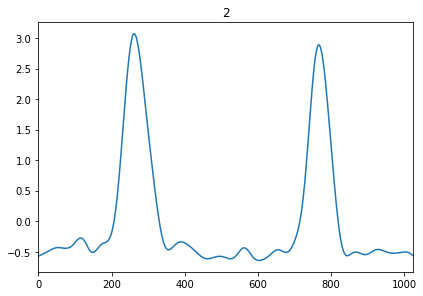

In [24]:
tfms = [None, [Categorize()]]
# tfms = None
# dsets = NumpyDatasets(X_on_disk, y_on_disk, tfms=tfms, sel_vars=None, sel_steps=None, splits=splits, inplace=True)
dsets = TSDatasets(X_in_memory, y_in_memory, sel_vars=None, sel_steps=None, tfms=tfms, splits=splits, inplace=True)
train_ds = dsets.train
valid_ds = dsets.valid
test_ds  = dsets.add_test(X_in_memory, y_in_memory)
print(valid_ds[0])
show_at(valid_ds, 0);

In [25]:
train_dl = TSDataLoader(train_ds, bs=64, shuffle=True, drop_last=True, num_workers=0)
valid_dl = TSDataLoader(valid_ds, bs=128, num_workers=0)
dls = TSDataLoaders(train_dl, valid_dl)
b = next(iter(dls.train))
b

(TSTensor(samples:64, vars:1, len:1024),
 tensor([2, 2, 2, 2, 2, 1, 2, 2, 0, 2, 2, 2, 2, 1, 2, 2, 0, 0, 1, 2, 2, 2, 2, 0,
         0, 0, 2, 2, 1, 1, 0, 2, 1, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 1, 1, 1, 2,
         1, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 2, 2]))

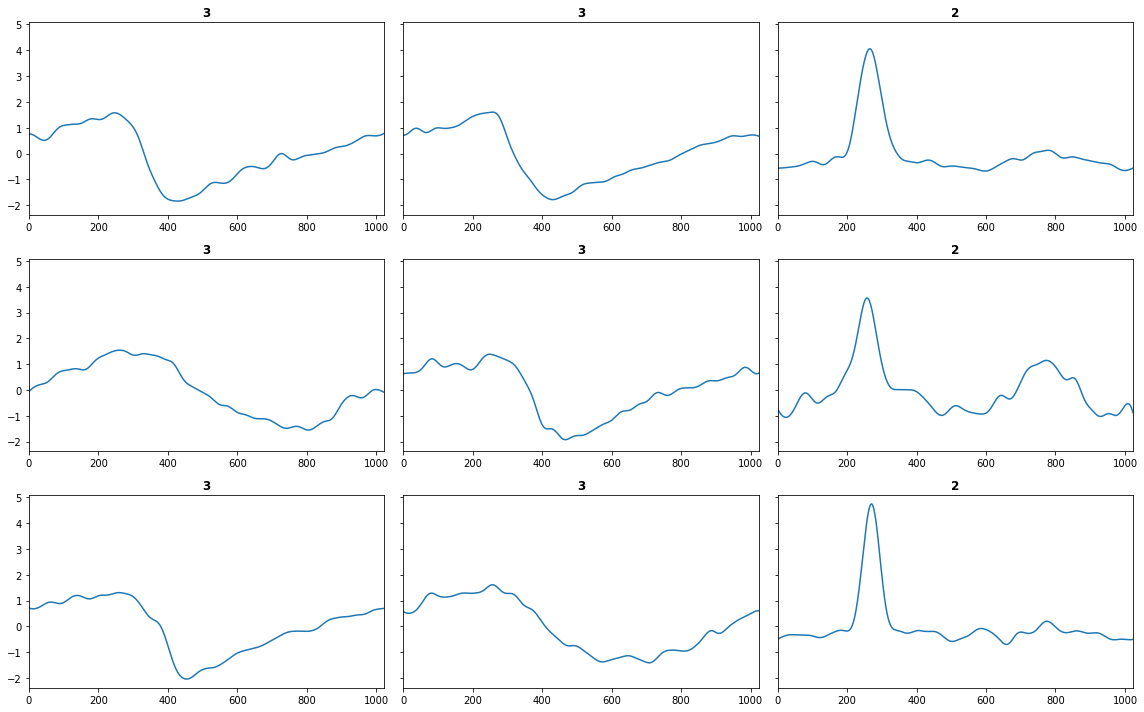

In [26]:
dls.train.show_batch(sharey=True)

Let's first establish another benchmark. 

If we think of it, the fastest and simplest way to create a batch to be used in fastai v2 would be to:

1. split the X and y between train and valid. This can be done at initialization. 

2. Slice the data based on random idx, cast the outputs to the expected classes, and create a tuple. 

This process takes about 175 µs. So it's very fast.

In [27]:
X_val = X_in_memory[splits[1]]
y_val = y_in_memory[splits[1]].astype(int)
tuple((TSTensor(X_val[valid_idx]), TensorCategory(y_val[valid_idx])))

(TSTensor(samples:128, vars:1, len:1024),
 TensorCategory([3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 1, 1, 1, 1, 3, 2, 3, 2, 3, 3,
         3, 1, 1, 2, 2, 2, 3, 3, 3, 2, 3, 3, 1, 3, 2, 1, 3, 1, 2, 3, 2, 3, 2, 3,
         3, 3, 3, 3, 2, 3, 3, 2, 1, 1, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2,
         3, 2, 2, 3, 2, 3, 2, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 2, 3, 1, 3, 2, 2, 3,
         2, 2, 1, 1, 3, 3, 3, 3, 3, 3, 2, 2, 1, 1, 3, 3, 1, 2, 2, 3, 3, 3, 2, 3,
         2, 2, 3, 1, 3, 3, 3, 1]))

In [28]:
%timeit tuple((TSTensor(X_val[valid_idx]), TensorCategory(y_val[valid_idx])))

The slowest run took 4.04 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 177 µs per loop


Let's see how does this compare to NumpyDatasets when tfms are not preprocessed:

In [29]:
valid_ds[valid_idx]

(TSTensor(samples:128, vars:1, len:1024),
 tensor([2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 0, 0, 0, 2, 1, 2, 1, 2, 2,
         2, 0, 0, 1, 1, 1, 2, 2, 2, 1, 2, 2, 0, 2, 1, 0, 2, 0, 1, 2, 1, 2, 1, 2,
         2, 2, 2, 2, 1, 2, 2, 1, 0, 0, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1,
         2, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 0, 2, 1, 1, 2,
         1, 1, 0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 0, 0, 2, 2, 0, 1, 1, 2, 2, 2, 1, 2,
         1, 1, 2, 0, 2, 2, 2, 0]))

In [30]:
# Preprocess = False
dsets = TSDatasets(X_in_memory, y_in_memory, sel_vars=None, sel_steps=None, tfms=tfms, splits=splits, inplace=False)
valid_ds = dsets.valid
valid_dl = TSDataLoader(valid_ds, bs=128, num_workers=0)
%timeit valid_ds[valid_idx]

100 loops, best of 3: 12.3 ms per loop


This is about 100 times slower. This makes the dataloader almost 20 times slower than the simple Pytorch dataloder whe showed before.

In [31]:
%timeit cycle_dl(valid_dl)

1 loop, best of 3: 805 ms per loop


Let's see how is performance when data is preprocessed:

In [32]:
# Preprocess = True
dsets = TSDatasets(X_in_memory, y_in_memory, sel_vars=None, sel_steps=None, tfms=tfms, splits=splits, inplace=True)
valid_ds = dsets.valid
valid_dl = TSDataLoader(valid_ds, bs=128, num_workers=0)
%timeit valid_ds[valid_idx]

10000 loops, best of 3: 127 µs per loop


Wow! Since we only perform slicing and casting at batch creation time performance is excellent. About 100 times faster than when not preprocessed. [link text](https:// [link text](https://))

In [33]:
%timeit cycle_dl(valid_dl)

10 loops, best of 3: 30.6 ms per loop


😲 This is the same level of performance we had with the Pytorch dataloader, but much more flexible and with many additional benefits ❣️

Let's now measure the timing with data on-disk instead of in memory.

In [34]:
# Preprocess = True
dsets = TSDatasets(X_on_disk, y_on_disk, sel_vars=None, sel_steps=None, tfms=tfms, splits=splits, inplace=True)
valid_ds = dsets.valid
valid_dl = TSDataLoader(valid_ds, bs=128, num_workers=0)
%timeit valid_ds[valid_idx]

10000 loops, best of 3: 124 µs per loop


In [35]:
%timeit cycle_dl(valid_dl)

10 loops, best of 3: 30.3 ms per loop


⚠️ Good, there's no impact in batch creation when the data is on disk!



Let's now compare the time to train the model.

In [36]:
# Preprocess = FALSE, Data in memory
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X_in_memory, y_in_memory, tfms=tfms, splits=splits, inplace=False)
train_ds = dsets.train
valid_ds = dsets.valid
train_dl = TSDataLoader(train_ds, bs=64, shuffle=True, drop_last=True, num_workers=0)
valid_dl = TSDataLoader(valid_ds, bs=128, num_workers=0)
dls   = TSDataLoaders(train_dl, valid_dl, device=default_device())
model = InceptionTime(dls.vars, dls.c)
learn2 = Learner(dls, model, metrics=accuracy)
start = time.time()
learn2.fit_one_cycle(25, lr_max=1e-3)
print(time.time() - start)

epoch,train_loss,valid_loss,accuracy,time
0,0.727645,1.067144,0.279869,00:03
1,0.594386,0.702179,0.849927,00:03
2,0.508360,0.406608,0.851506,00:03
3,0.430965,0.358617,0.908451,00:03
4,0.369370,0.256972,0.869961,00:03
5,0.317290,0.376902,0.858184,00:03
6,0.272730,0.174848,0.951311,00:03
7,0.229925,0.160899,0.936498,00:03
8,0.193093,0.245744,0.910393,00:03
9,0.171099,0.208830,0.951676,00:03


97.49403381347656


⚠️ This NumpyDataLoader is already a bit faster than fastai v1. But we have not yet used preprocess = True. 

In [37]:
# Preprocess = TRUE, Data in memory
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X_in_memory, y_in_memory, tfms=tfms, splits=splits, inplace=True)
train_ds = dsets.train
valid_ds = dsets.valid
train_dl = TSDataLoader(train_ds, bs=64, shuffle=True, drop_last=True, num_workers=0)
valid_dl = TSDataLoader(valid_ds, bs=128, num_workers=0)
dls   = TSDataLoaders(train_dl, valid_dl, device=default_device())
model = InceptionTime(dls.vars, dls.c)
learn = Learner(dls, model, metrics=accuracy)
start = time.time()
learn.fit_one_cycle(25, lr_max=1e-3)
print(time.time() - start)

epoch,train_loss,valid_loss,accuracy,time
0,0.696308,0.955160,0.577222,00:02
1,0.566781,0.631734,0.809252,00:02
2,0.484536,0.390655,0.841549,00:02
3,0.408365,0.604181,0.627853,00:02
4,0.348453,0.187276,0.951797,00:02
5,0.291109,0.719341,0.856727,00:02
6,0.253515,0.242613,0.901044,00:02
7,0.216610,0.200984,0.925328,00:02
8,0.188960,1.469944,0.483609,00:02
9,0.167941,0.264442,0.885746,00:02


73.11140632629395


🍻 🎉 I think this is a great result. It means that just preprocessing the item transforms can reduce training time by almost 25%, and almost 50% from the generic datablock API. 

In [38]:
# Preprocess = TRUE, Data on disk
tfms = [None, [Categorize()]]
dsets = TSDatasets(X_on_disk, y_on_disk, tfms=tfms, splits=splits, inplace=True)
train_ds = dsets.train
valid_ds = dsets.valid
train_dl = TSDataLoader(train_ds, bs=64, shuffle=True, drop_last=True)
valid_dl = TSDataLoader(valid_ds, bs=128)
dls = TSDataLoaders(train_dl, valid_dl, device=default_device())
model = InceptionTime(dls.vars, dls.c)
learn = Learner(dls, model, metrics=accuracy)
start = time.time()
learn.fit_one_cycle(25, lr_max=1e-3)
print(time.time() - start)

epoch,train_loss,valid_loss,accuracy,time
0,0.758086,1.006821,0.579772,00:03
1,0.607912,0.655561,0.835843,00:03
2,0.514340,0.418256,0.850291,00:03
3,0.430684,0.279880,0.909058,00:03
4,0.357841,0.480854,0.856362,00:03
5,0.303761,0.799582,0.856241,00:03
6,0.255067,0.171060,0.945119,00:03
7,0.213089,0.232255,0.906265,00:03
8,0.181367,0.189762,0.939898,00:03
9,0.159745,0.288204,0.875789,00:03


81.07562470436096


⚠️ This is also very important, as it means we can now train very large datasets with a good performance without loading data in memory. It takes around 10% longer.

#### Predictions

NumpyDatasets and NumpyDataLoader share all the benefits of fastai v2:

In [39]:
# Preprocess = TRUE, Data in memory
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X_in_memory, y_in_memory, tfms=tfms, splits=splits, inplace=True)
train_dl = TSDataLoader(dsets.train, bs=64, shuffle=True, drop_last=True, num_workers=0)
valid_dl = TSDataLoader(dsets.valid, bs=128, num_workers=0)
dls   = TSDataLoaders(train_dl, valid_dl, device=default_device())
model = InceptionTime(dls.vars, dls.c)
learn = Learner(dls, model, metrics=accuracy)
learn.fit_one_cycle(3, lr_max=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.623371,0.868707,0.839121,00:02
1,0.477802,0.496088,0.851141,00:02
2,0.395283,0.462894,0.906022,00:02


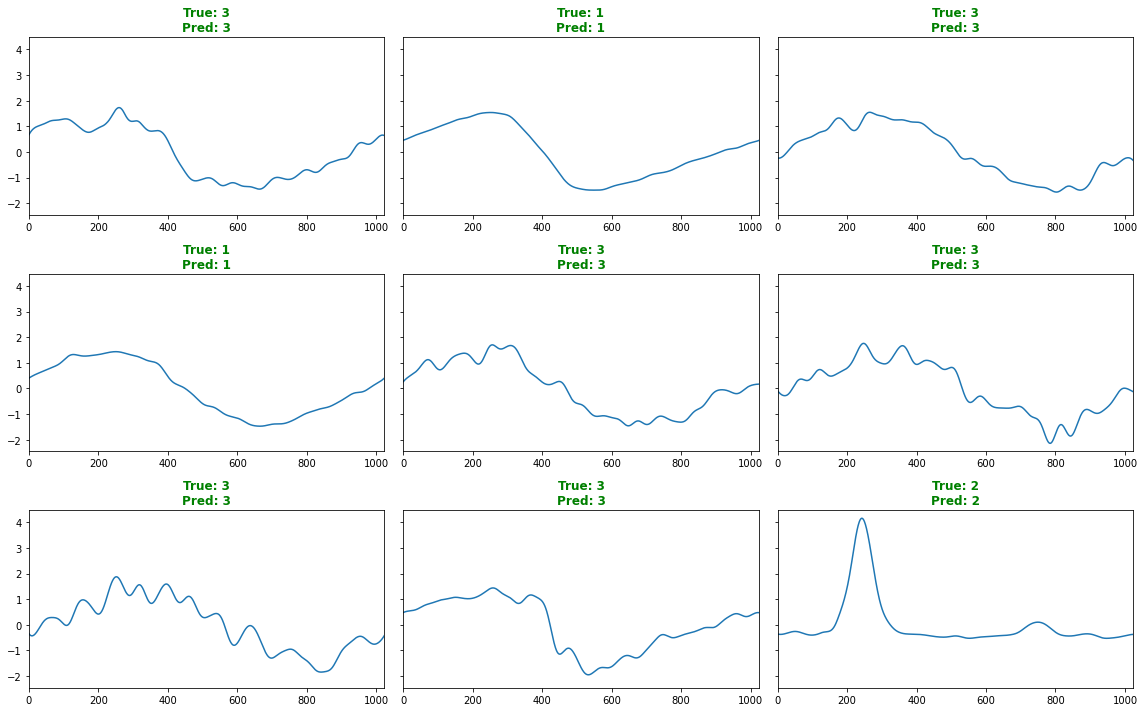

In [40]:
learn.show_results(sharey=True)

In [41]:
train_probas, train_targets, train_preds = learn.get_preds(dl=train_dl, with_decoded=True)
valid_probas, valid_targets, valid_preds = learn.get_preds(dl=valid_dl, with_decoded=True)
valid_probas, valid_targets, valid_preds

(tensor([[0.0095, 0.9771, 0.0133],
         [0.3646, 0.2382, 0.3972],
         [0.3949, 0.2159, 0.3892],
         ...,
         [0.4822, 0.0898, 0.4280],
         [0.0166, 0.9606, 0.0227],
         [0.2271, 0.0792, 0.6936]]),
 tensor([1, 2, 2,  ..., 0, 1, 2]),
 tensor([1, 2, 0,  ..., 0, 1, 2]))

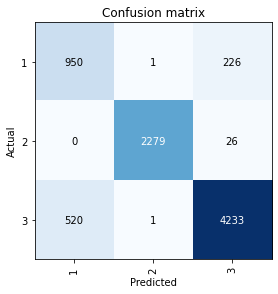

In [42]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

### Add additional labeled test data

In [43]:
# Labeled test data
test_ds = dsets.add_test(X_in_memory, y_in_memory)
test_dl = learn.dls[1].new(test_ds)
b = next(iter(test_dl))
b

(TSTensor(samples:128, vars:1, len:1024),
 tensor([2, 2, 0, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 0, 1, 2, 1, 2, 0, 1, 0,
         2, 2, 0, 2, 2, 2, 1, 2, 1, 1, 2, 0, 0, 1, 2, 0, 1, 2, 1, 2, 2, 1, 1, 2,
         0, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 1, 2, 2, 2, 0, 1, 2, 2, 2, 2, 1, 1, 2,
         1, 0, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 0, 2, 2, 1, 1, 2, 0, 2, 2, 2, 1,
         2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 2, 0, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1,
         2, 2, 2, 2, 1, 2, 0, 2], device='cuda:0'))

In [44]:
test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
test_probas, test_targets, test_preds

(tensor([[0.3812, 0.0904, 0.5284],
         [0.5293, 0.0799, 0.3908],
         [0.5227, 0.0845, 0.3928],
         ...,
         [0.4822, 0.0898, 0.4280],
         [0.0166, 0.9606, 0.0227],
         [0.2271, 0.0792, 0.6936]]),
 tensor([2, 2, 0,  ..., 0, 1, 2]),
 tensor([2, 0, 0,  ..., 0, 1, 2]))

### Add additional unlabeled test data

In [45]:
# Unlabeled test data
test_ds = dsets.add_test(X_in_memory)
test_dl = learn.dls[1].new(test_ds)
b = next(iter(test_dl))
b

(TSTensor(samples:128, vars:1, len:1024),)

In [46]:
test_probas, *_ = learn.get_preds(dl=test_dl, save_preds=None)
test_probas

tensor([[0.3812, 0.0904, 0.5284],
        [0.5293, 0.0799, 0.3908],
        [0.5227, 0.0845, 0.3928],
        ...,
        [0.4822, 0.0898, 0.4280],
        [0.0166, 0.9606, 0.0227],
        [0.2271, 0.0792, 0.6936]])

### Add additional unlabeled data

In [47]:
# Unlabeled dataset
unlabeled_ds = dsets.add_unlabeled(X_in_memory)
unlabeled_dl = learn.dls[1].new(unlabeled_ds)
b = next(iter(unlabeled_dl))
b

(TSTensor(samples:128, vars:1, len:1024),)

In [48]:
u_probas, *_ = learn.get_preds(dl=unlabeled_dl, save_preds=None)
u_probas

tensor([[0.3812, 0.0904, 0.5284],
        [0.5293, 0.0799, 0.3908],
        [0.5227, 0.0845, 0.3928],
        ...,
        [0.4822, 0.0898, 0.4280],
        [0.0166, 0.9606, 0.0227],
        [0.2271, 0.0792, 0.6936]])

## Conclusions 🧠

We now have a dataloader that works with numpy arrays and meets all the requirements we set at the beginning of this notebook. The key benefits are: 

* We can use it with numpy arrays (or anything that can be converted into np arrays). For example, this can be used for **univariate and multivariate time series**.
* Easy to use scikit-learn type of API (X, (y)), useful for **labeled and unlabeled datasets**
* We can also use **larger than RAM datasets**, keeping data on disk.
* It has all the benefits of being integrated with fastai v2: 
    * Use item and batch tfms
    * Show batch (with tfms)
    * Show results
* The dataloader is **300 times faster than fastai v1** and **1000 times faster than generic fastai v2** (with numpy arrays).
* This results in almost **30% faster training** fastai v1 and around **50% faster generic fastai v2** (for numpy arrays)